*Use this notebook to complete the sentence similarity and embedding visualization tasks.*


# Sentence Similarity

In [15]:
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')

from nltk.tokenize import word_tokenize

def tokenize_text(text):
    return word_tokenize(text.lower())

[nltk_data] Downloading package punkt_tab to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
import numpy as np
def cosine_similarity(a, b, eps=1e-12):
    denom = (np.linalg.norm(a) * np.linalg.norm(b)) + eps
    return float(np.dot(a, b) / denom)

## Sentence embedding from PKL files

In [7]:
import pickle
def load_pkl(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
        return data

def sentence_embedding_pkl(text, pkl):
    tokens = tokenize_text(text)
    embeddings = pkl['embeddings']
    word2idx = pkl['word2idx']
    vecs = [embeddings[word2idx[w]] for w in tokens if w in word2idx]
    if not vecs:
        return np.zeros(embeddings.shape[1], dtype=np.float32)
    return np.mean(np.asarray(vecs, dtype=np.float32), axis=0)

## Sentence embedding from Model files

In [62]:
from gensim.models import Word2Vec, FastText, KeyedVectors

def load_kv_from_model(path):
    try:
        return KeyedVectors.load(path, mmap="r")
    except Exception:
        pass

    # full models
    try:
        return Word2Vec.load(path).wv
    except Exception:
        pass

    try:
        return FastText.load(path).wv
    except Exception:
        pass

    raise ValueError(f"Could not load a gensim model/KeyedVectors from: {path}")

def sentence_embedding_from_kv(text, kv, tokenizer=tokenize_text, allow_oov_fasttext=False):
    tokens = tokenizer(text)
    vecs = []

    for w in tokens:
        if w in kv.key_to_index:
            vecs.append(kv[w])
        elif allow_oov_fasttext and hasattr(kv, "get_vector"):
            vecs.append(kv.get_vector(w))

    if not vecs:
        return np.zeros(kv.vector_size, dtype=np.float32)

    return np.mean(np.stack(vecs, axis=0), axis=0)

In [63]:
import pandas as pd

def similarity_table(models, sentences, target):
    
    rows = {}

    for m in models:
        name = m["name"]
        mtype = m["type"]
        path = m["path"]

        if mtype == "pkl":
            pkl_obj = load_pkl(path)
            target_vec = sentence_embedding_pkl(target, pkl_obj)

            sims = []
            for s in sentences:
                s_vec = sentence_embedding_pkl(s, pkl_obj)
                sims.append(cosine_similarity(s_vec, target_vec))

        elif mtype == "model":
            kv = load_kv_from_model(path)

            allow_oov = "fasttext" in path.lower()

            target_vec = sentence_embedding_from_kv(target, kv, allow_oov_fasttext=allow_oov)

            sims = []
            for s in sentences:
                s_vec = sentence_embedding_from_kv(s, kv, allow_oov_fasttext=allow_oov)
                sims.append(cosine_similarity(s_vec, target_vec))

        else:
            raise ValueError(f"Unknown model type: {mtype} (expected 'pkl' or 'model')")

        rows[name] = sims

    df = pd.DataFrame(rows, index=sentences).T
    df.columns = sentences
    return df

In [31]:
sentences = [
    "The cat sat on the mat.",
    "A dog is playing in the yard.",
    "I need to buy groceries today.",
    "The feline was resting on the rug.",
    "Canines enjoy outdoor activities.",
    "My shopping list includes milk and bread.",
    "The weather is beautiful today.",
    "Programming requires logical thinking."
]
query = "My pet cat is sleeping on the carpet."

models = [
    {"name": "PyTorch", "type": "pkl", "path": "word2vec_embeddings.pkl"},
    {"name": "Gensim", "type": "pkl", "path": "word2vec_gensim_embeddings.pkl"},
    {"name": "Google News", "type": "model", "path": "word2vec-google-news-300.model"},
    {"name": "FastText Wiki", "type": "model", "path": "fasttext-wiki-news-subwords-300.model"}
]


In [32]:
similarity_table(models, sentences, query)

,The cat sat on the mat.,A dog is playing in the yard.,I need to buy groceries today.,The feline was resting on the rug.,Canines enjoy outdoor activities.,My shopping list includes milk and bread.,The weather is beautiful today.,Programming requires logical thinking.
PyTorch,0.544488,0.363162,0.141863,0.285371,0.061185,0.292998,0.265320,0.116317
Gensim,0.697932,0.602897,0.173199,0.500541,0.085964,0.475165,0.493686,0.072120
Google News,0.736872,0.648278,0.371789,0.779382,0.428147,0.496959,0.431013,0.297923
FastText Wiki,0.911408,0.851180,0.585846,0.924730,0.650420,0.834956,0.809037,0.613466


# Embedding Visualization

In [64]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap

def get_loaded(model):
    # cache on the model dict itself
    if "_loaded" in model:
        return model["_loaded"]

    if model["type"] == "pkl":
        model["_loaded"] = load_pkl(model["path"])
    elif model["type"] == "model":
        model["_loaded"] = load_kv_from_model(model["path"])
    else:
        raise ValueError(f"Unknown type: {model['type']}")
    return model["_loaded"]

def get_vec_from_source(model, word):
    loaded = get_loaded(model)

    if model["type"] == "pkl":
        w2i = loaded["word2idx"]
        if word not in w2i:
            return None
        return np.asarray(loaded["embeddings"][w2i[word]], dtype=np.float32)

    # model -> KeyedVectors
    kv = loaded
    if word in kv.key_to_index:
        return np.asarray(kv[word], dtype=np.float32)

    if model.get("allow_oov", False) and hasattr(kv, "get_vector"):
        return np.asarray(kv.get_vector(word), dtype=np.float32)

    return None
    
def build_X(words_by_cat, source):
    X, labels, words = [], [], []
    for cat, ws in words_by_cat.items():
        for w in ws:
            v = get_vec_from_source(source, w)
            if v is not None:
                X.append(v)
                labels.append(cat)
                words.append(w)
    return np.stack(X, axis=0), np.array(labels), words

def plot_on_ax(ax, points, labels, words, title):
    color_map = {"animals": "tab:blue", "foods": "tab:orange"}
    colors = [color_map[l] for l in labels]

    ax.scatter(points[:, 0], points[:, 1], c=colors)
    for (x, y), w in zip(points, words):
        ax.text(x, y, w, fontsize=9)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    for spine in ax.spines.values():
        spine.set_visible(True)

def visualize_embeddings(models, animals, foods):
    words_by_cat = {"animals": animals, "foods": foods}

    for m in models:
        X, labels, words = build_X(words_by_cat, m)

        # t-SNE
        perp = min(10, max(2, X.shape[0] - 1))
        pts_tsne = TSNE(
            n_components=2, perplexity=perp, init="pca",
            learning_rate="auto", random_state=0
        ).fit_transform(X)

        # UMAP
        pts_umap = umap.UMAP(
            n_components=2, n_neighbors=10, min_dist=0.3,
            metric="cosine", random_state=0
        ).fit_transform(X)

        # subplots
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        fig.suptitle(m["name"], fontsize=16)

        plot_on_ax(axes[0], pts_tsne, labels, words, "t-SNE")
        plot_on_ax(axes[1], pts_umap, labels, words, "UMAP")

        plt.tight_layout(rect=[0, 0, 1, 0.94])
        plt.show()

In [58]:
animals = [
    'dog', 'cat', 'horse', 'cow',
    'lion', 'tiger', 'elephant', 'giraffe',
    'eagle', 'hawk', 'sparrow', 'penguin',
    'shark', 'whale', 'dolphin', 'tuna'
]

foods = [
    'apple', 'orange', 'banana', 'grape',
    'bread', 'pasta', 'rice', 'potato',
    'chicken', 'beef', 'pork', 'fish',
    'coffee', 'tea', 'juice', 'water'
]

/opt/conda/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


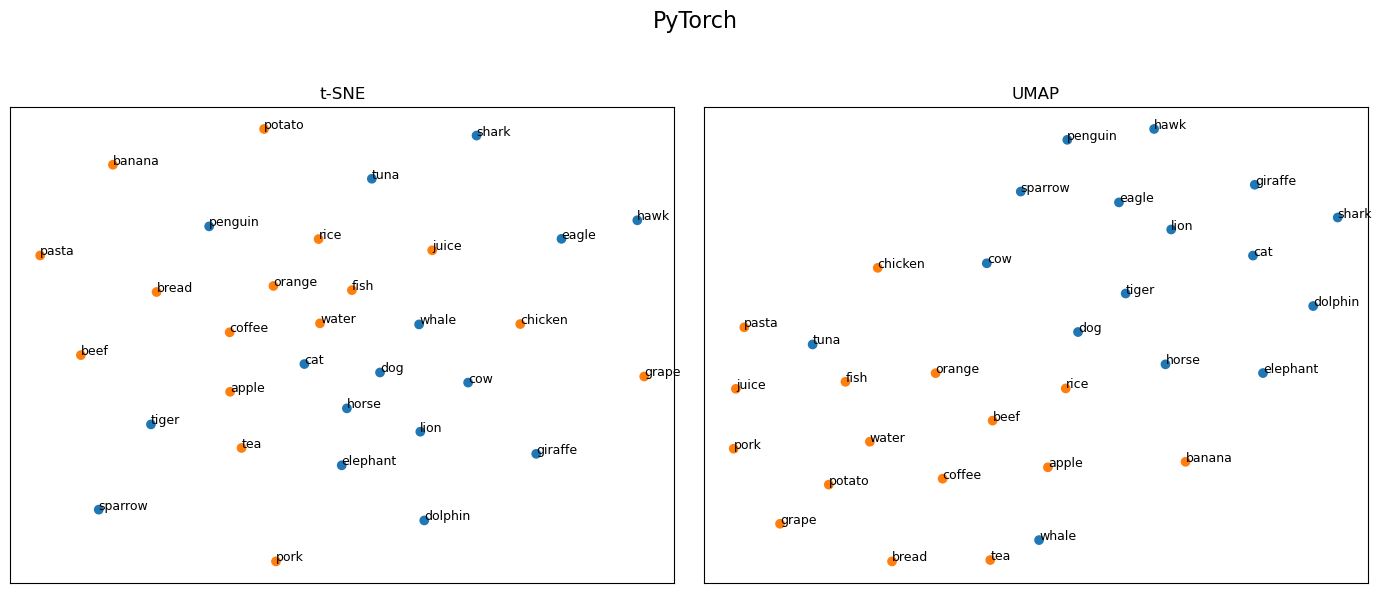

/opt/conda/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


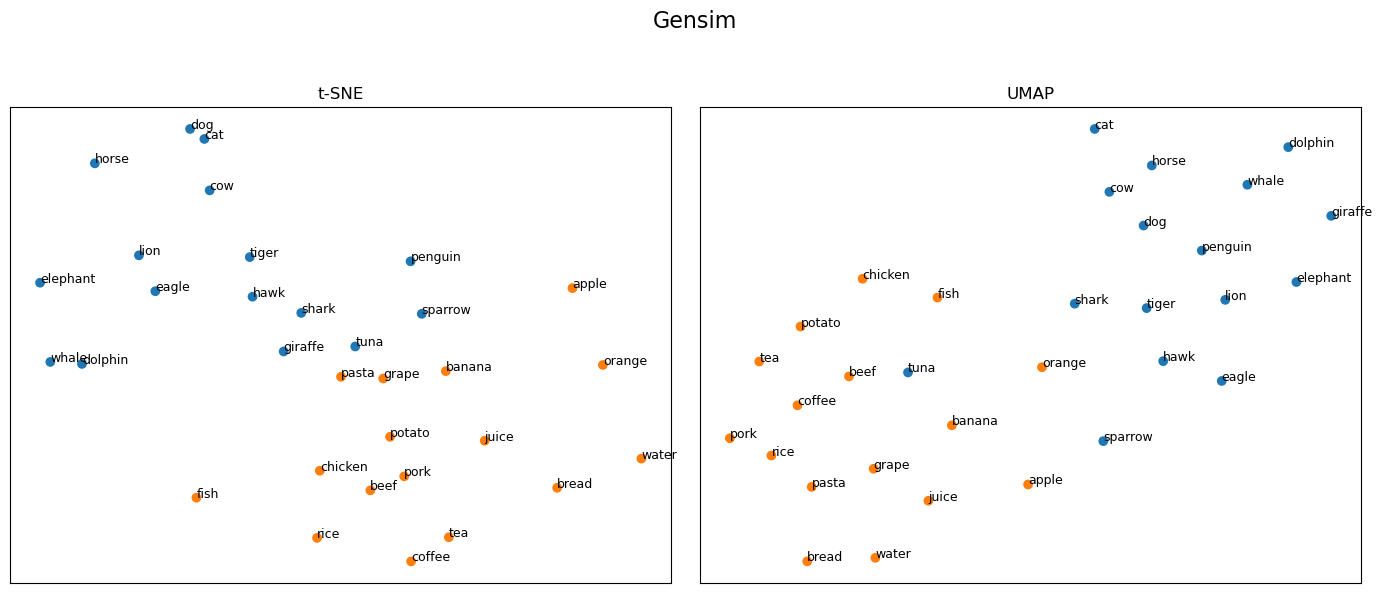

/opt/conda/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


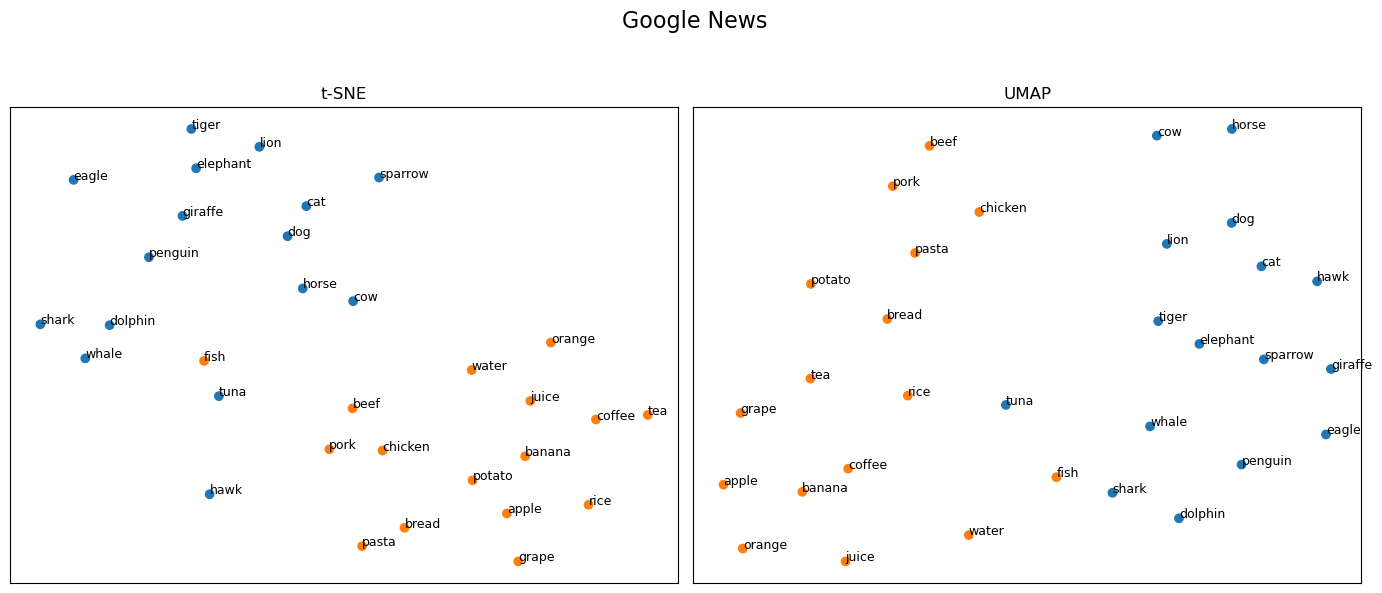

/opt/conda/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


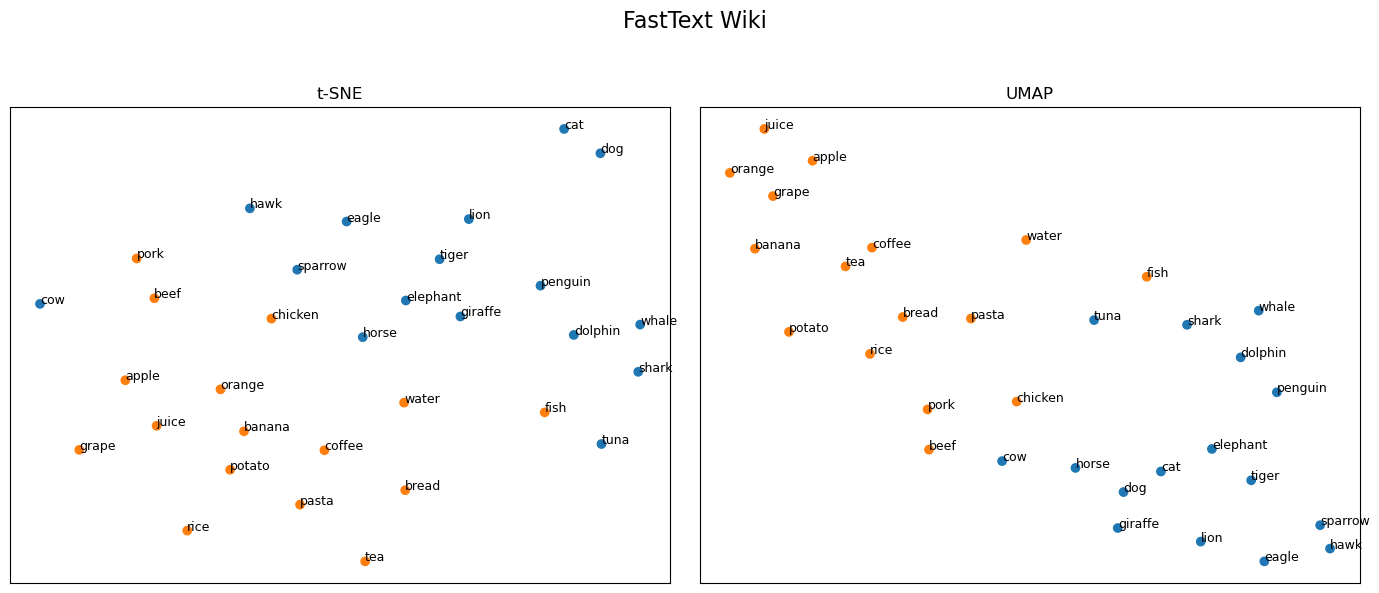

In [61]:
visualize_embeddings(models, animals, foods)

## Short Answer Questions
FastTest Wiki seemed to perform the best. It gave the first and fourth sentences ("The cat sat-" "The feline was-") the highest scores, which is correct, as they should hold the closest meaning to our comparison sentence. We see that others gave sentences about a dog higher scores, so their models did not accurately identify the semantic differences of the two. 
Comparing the results to my own embeddings, these embeddings performed much better. This makes sense because the pretrained embeddings were already trained on a lot more tokens. Also, Word2Vec that we used is trying to predict context, so it is reasonable that it would not capture semantics or sentence structure as well as the others.

## AI Use Disclosure (Required)

If you used any AI-enabled tools (e.g., ChatGPT, GitHub Copilot, Claude, or other LLM assistants) while working on this assignment, you must disclose that use here. The goal is transparency-not punishment.

In your disclosure, briefly include:
- **Tool(s) used:** (name + version if known)
- **How you used them:** (e.g., concept explanation, debugging, drafting code, rewriting text)
- **What you verified yourself:** (e.g., reran the notebook, checked outputs/plots, checked shapes, read documentation)
- **What you did *not* use AI for (if applicable):** (optional)

You are responsible for the correctness of your submission, even if AI suggested code or explanations.

#### <font color="red">Write your disclosure here.</font>


I used ChatGPT for general idea of code when not sure where to start. I then read, understood the code, and edited it to fit our task. 